In [2]:
import matplotlib.pyplot as plt
from torch import nn
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import math
import random
import warnings
import torchvision
from collections.abc import Callable
from sklearn.model_selection import train_test_split

## Utils

In [3]:
def diag_mat_weights(dimp, type = 'first'):
    if type == 'first':
        dg = np.zeros((dimp-1, dimp))
        for i in range(dimp-1):
            dg[i,i] = -1
            dg[i,i+1]= 1
    elif type == 'second':
        dg = np.zeros((dimp-2, dimp))
        for i in range(dimp-2):
            dg[i,i] = -1
            dg[i,i+1]= 2
            dg[i,i+2]= -1
    else:
        pass
    return torch.Tensor(dg)
    
def normalize_columns(tensor, type = None):
    # Calculate the maximum value for each column
    if type == 'standard':
        mean, std = tensor.mean(dim = 0), tensor.std(dim = 0)
    
        # Normalize each column by dividing by its maximum value
        for i in range(tensor.size()[1]):
            tensor[:,i] = (tensor[:,i]- mean[i])/std[i]
    else:
        Max, Min = tensor.max(dim = 0)[0], tensor.min(dim = 0)[0]
    
        # Normalize each column by dividing by its maximum value
        for i in range(tensor.size()[1]):
            tensor[:,i] = (tensor[:,i]- Min[i])/(Max[i] - Min[i])
    
    return tensor

def ECM(model, num_neurons, num_knots, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4, L = None):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi

    if L == 1:
        B = model.inter['ebasic']
        By = model.inter['basic']
        WB = model.sp1.control_p
    else:
        B = model.inter['ebasic2']
        By = model.inter['basic2']
        WB = model.sp2.control_p
        
    DB = diag_mat_weights(WB.size()[0]).to(device)
    size = B.size()[1]
    S = DB.T @ DB
    Cov_a = (xi**2)* torch.linalg.pinv(S)
    Cov_e = torch.eye(size*num_neurons)* sigma
    
    block_y = torch.reshape(By, (-1,1))
    flatB = B.view(num_neurons, num_knots, size)
        
    sqr_xi= 0
    sqr_sig = 0
    
    for i in range(num_neurons):
        Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
        Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
        
        first_xi = S @ Ncov
        second_xi = (Nmu.T @ S @ Nmu)
        sqr_xi += torch.trace(first_xi) + second_xi
            
        first_sig = torch.norm(By[:,i])
        second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
        third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
        four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
        
        sqr_sig += (first_sig + second_sig + third_sig + four_sig)
    
    sqr_xi /= num_neurons
    sqr_sig /= (num_neurons*size)
    
    Lambda = sqr_sig/sqr_xi
    
    return Lambda.item()

def psurvival(t, eta, beta):
    return 1-np.exp(-(t/eta)**beta)

## Data preprocessomg

In [4]:
trainsample = np.array(pd.read_csv('/Users/a080528/Desktop/Github/DBspline/trainsample.csv'))
testsample = np.array(pd.read_csv('/Users/a080528/Desktop/Github/DBspline/testsample.csv'))

In [5]:
# Three size of chip
WLsize = [6.4*10**(-4), 6.4*10**(-6), 6.4*10**(-8)]

# Fix A, a, b, c, d, V
A = 5*10**(-7); a = -78; b = 0.081; c = 8.81*10**(3); d = -7.75 * 10**(5); V = 1.2

# Change size, beta, and Temperature
beta = 1.64; T = 120; WL = 6.4*10**(-4)

# upper and lower bound
lA = 4.75*10**(-7); uA = 5.25*10**(-7)
la = -74.1; ua = -81.9
lb = 7.695 * 10**(-2); ub = 8.505 * 10**(-2)
lc =  8.369*10**(3); uc =  9.250*10**(3)
ld = -7.3265 * 10**(5); ud = -8.1375 * 10**(5)

lbeta = 1.476; ubeta = 1.804
lT = 120; uT = 180
lV = 1.2; uV = 1.3
lWL = 6*10**(-4); uWL = 4*10**(-4)

# sampling 
sample_train_A = lA + trainsample[:,0]*(uA - lA)
sample_train_a = la + trainsample[:,1]*(ua - la)
sample_train_b = lb + trainsample[:,2]*(ub - lb)
sample_train_c = lc + trainsample[:,3]*(uc - lc)
sample_train_d = ld + trainsample[:,4]*(ud - ld)
sample_train_beta = lbeta + trainsample[:,5]*(ubeta - lbeta)
sample_train_T = lT + trainsample[:,6]*(uT - lT)
sample_train_V = lV + trainsample[:,7]*(uV - lV)
sample_train_WL = lWL + trainsample[:,8]*(uWL - lWL)
sample_train_eta = sample_train_A*(sample_train_WL*np.exp(1))**(-1/sample_train_beta)*(sample_train_V**(sample_train_a+sample_train_b*sample_train_T))*np.exp((sample_train_c*sample_train_T+sample_train_d)/sample_train_T**2)


sample_test_beta = lbeta + testsample[:,0]*(ubeta - lbeta)
sample_test_T = lT + testsample[:,1]*(uT - lT)
sample_test_WL = lWL + testsample[:,2]*(uWL - lWL)
sample_test_eta = A*(sample_test_WL*np.exp(1))**(-1/sample_test_beta)*(V**(a+b*sample_test_T))*np.exp((c*sample_test_T+d)/sample_test_T**2)

sample_test_A = lA + testsample[:,0]*(uA - lA)
sample_test_a = la + testsample[:,1]*(ua - la)
sample_test_b = lb + testsample[:,2]*(ub - lb)
sample_test_c = lc + testsample[:,3]*(uc - lc)
sample_test_d = ld + testsample[:,4]*(ud - ld)
sample_test_beta = lbeta + testsample[:,5]*(ubeta - lbeta)
sample_test_T = lT + testsample[:,6]*(uT - lT)
sample_test_V = lV + testsample[:,7]*(uV - lV)
sample_test_WL = lWL + testsample[:,8]*(uWL - lWL)
sample_test_eta = sample_test_A*(sample_test_WL*np.exp(1))**(-1/sample_test_beta)*(sample_test_V**(sample_test_a+sample_test_b*sample_test_T))*np.exp((sample_test_c*sample_test_T+sample_test_d)/sample_test_T**2)

In [30]:
ndim = 9
n = sample_train_beta.shape[0]
X_train = torch.zeros((sample_train_beta.shape[0], ndim))
X_test = torch.zeros((sample_test_beta.shape[0], ndim))

X_train[:,0] = torch.Tensor(sample_train_A)
X_train[:,1] = torch.Tensor(sample_train_a)
X_train[:,2] = torch.Tensor(sample_train_b)
X_train[:,3] = torch.Tensor(sample_train_c)
X_train[:,4] = torch.Tensor(sample_train_d)
X_train[:,5] = torch.Tensor(sample_train_beta)
X_train[:,6] = torch.Tensor(sample_train_T)
X_train[:,7] = torch.Tensor(sample_train_V)
X_train[:,8] = torch.Tensor(sample_train_WL)


X_test[:,0] = torch.Tensor(sample_test_A)
X_test[:,1] = torch.Tensor(sample_test_a)
X_test[:,2] = torch.Tensor(sample_test_b)
X_test[:,3] = torch.Tensor(sample_test_c)
X_test[:,4] = torch.Tensor(sample_test_d)
X_test[:,5] = torch.Tensor(sample_test_beta)
X_test[:,6] = torch.Tensor(sample_test_T)
X_test[:,7] = torch.Tensor(sample_test_V)
X_test[:,8] = torch.Tensor(sample_test_WL)

y_train = torch.Tensor(sample_train_eta).reshape(-1, 1)
y_test = torch.Tensor(sample_test_eta).reshape(-1, 1)

X_train, X_test = normalize_columns(X_train, type = 'standard'), normalize_columns(X_test, type = 'standard')


In [31]:
trainsize, testsize = 1000, 400


aprange = [(y_train >= 1) & (y_train<= 30)]
DataX, Datay = X_train[aprange[0][:,0]], y_train[aprange[0][:,0]]

indice = random.sample(range(DataX.size()[0]), trainsize + testsize)
train_indice, test_indice = torch.tensor(indice[:trainsize]), torch.tensor(indice[trainsize:])

X_train, X_test, y_train, y_test = DataX[train_indice,:], DataX[test_indice,:], Datay[train_indice], Datay[test_indice]
y_train, y_test = torch.log(y_train), torch.log(y_test)

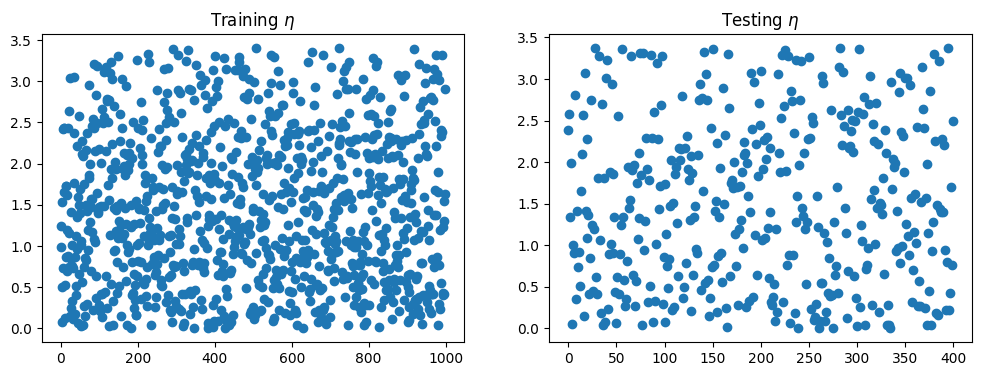

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(np.arange(y_train.shape[0]), y_train)
plt.title('Training $\eta$')
plt.subplot(1,2,2)
plt.scatter(np.arange(y_test.shape[0]), y_test)
plt.title('Testing $\eta$')
plt.show()

# Modeling

## DNN-S

In [9]:
class PRODBSplineLayerMultiFeature(nn.Module):
    def __init__(self, input_dim, degree, num_knots, output_dim, num_neurons, bias = True):
        super(PRODBSplineLayerMultiFeature, self).__init__()
        self.degree = degree
        self.num_knots = num_knots
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        
        if input_dim == 2:
            self.control_p = nn.Parameter(torch.randn(self.num_knots**2, self.output_dim))
        else:
            self.control_p = nn.Parameter(torch.randn(self.num_knots, self.num_neurons))
        if bias:
            self.bias = nn.Parameter(torch.randn(self.num_neurons))
        else:
            self.register_parameter('bias', None)
            
        self.inter = {}
    
    def basis_function(self, x, i, k, t):
    
        # Base case: degree 0 spline
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
    
        # Recursive case
        denom1 = t[i + k] - t[i]
        denom2 = t[i + k + 1] - t[i + 1]
    
        term1 = 0
        if denom1 != 0:
            term1 = (x - t[i]) / denom1 * self.basis_function(x, i, k - 1, t)
    
        term2 = 0
        if denom2 != 0:
            term2 = (t[i + k + 1] - x) / denom2 * self.basis_function(x, i + 1, k - 1, t)
    
        return term1 + term2
    
    def forward(self, x):
        batch_size, num_features = x.size()
        device = x.device
        
        # Create knot vector
        # knots = torch.linspace(0, 1, self.num_knots + self.degree + 1).to(device)
        knots = torch.cat([
                        torch.zeros(self.degree),               # Add repeated values at the start for clamping
                        torch.linspace(0, 1, self.num_knots - self.degree + 1),  # Uniform knot spacing in the middle
                        torch.ones(self.degree)                 # Add repeated values at the end for clamping
                    ]).to(device)
        # Apply B-spline basis functions for each feature
        basises = []
    
        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            basis = torch.stack([self.basis_function(x[:, feature], i, self.degree, knots) 
                                 for i in range(self.num_knots)], dim=-1)
            basises.append(basis)
            
        
        if num_features == 1:
            tout = basises[0] @ self.control_p
            self.inter['eachbasic'] = basises[0].T
        else:
            self.inter['eachbasic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
            basises = torch.stack(basises)
            tout = basises.permute(1,2,0) * self.control_p
            tout = tout.sum(dim =1)
                
        if self.bias is not None:
            tout += self.bias        

        self.inter['basicoutput'] = tout
        return tout


class NormLayer(nn.Module):
    def __init__(self):
        super(NormLayer, self).__init__()

    def forward(self, x):
        min_val = torch.min(x, axis = 1).values.reshape(-1,1)
        max_val = torch.max(x, axis = 1).values.reshape(-1,1)

        x = (x - min_val)/(max_val - min_val)  # Rescale to [0, 1]
        return x.detach()

In [10]:
class DNNS1(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, output_dim, bias):
        super(DNNS1, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        self.nm1 = NormLayer() 
        self.sp1 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        self.relu = nn.ReLU()
        self.inter = {}
        
    def forward(self, x):
        ln1out = self.ln1(x)
        ln1out = self.nm1(ln1out)
        
        device = ln1out.device
        batch_size, _ = x.size()
        
        # # # # # # # # # # # # # #
        #         SPLINE 1        #
        # # # # # # # # # # # # # #
        
        sp1out = self.sp1(ln1out)
        ln2out = self.ln2(sp1out)
        
        return ln2out

def num_para(model):
    tp = 0
    for param in model.parameters():
        tp += param.numel()
    return tp

### Experiment setting

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nm = 50; dg = 3; nk = 15; Fin = ndim; Fout = 1;
model = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
print('Number of Parameters: ', num_para(model))

learning_r = 1e-2
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_r)
Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = np.inf

Number of Parameters:  1101


### Simulated data training

In [62]:
for t in range(Iteration):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = model(X_train)
    loss = criterion(y_train, pyb_af); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat != 0) and (tpat != 0) and (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            #print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            #torch.save(model.state_dict(), './Chip'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        else:
            tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')

| Epoch:  1 / 10000  | Loss:  2.7586  |
| Epoch:  2 / 10000  | Loss:  1.5113  |
| Epoch:  3 / 10000  | Loss:  0.9548  |
| Epoch:  4 / 10000  | Loss:  0.9756  |
| Epoch:  5 / 10000  | Loss:  1.2514  |
| Epoch:  6 / 10000  | Loss:  1.4287  |
| Epoch:  7 / 10000  | Loss:  1.3978  |
| Epoch:  8 / 10000  | Loss:  1.231  |
| Epoch:  9 / 10000  | Loss:  1.0377  |
| Epoch:  10 / 10000  | Loss:  0.9  |
| Epoch:  11 / 10000  | Loss:  0.8529  |
| Epoch:  12 / 10000  | Loss:  0.8851  |
| Epoch:  13 / 10000  | Loss:  0.9539  |
| Epoch:  14 / 10000  | Loss:  1.0105  |
| Epoch:  15 / 10000  | Loss:  1.0243  |
| Epoch:  16 / 10000  | Loss:  0.9913  |
| Epoch:  17 / 10000  | Loss:  0.9283  |
| Epoch:  18 / 10000  | Loss:  0.8614  |
| Epoch:  19 / 10000  | Loss:  0.8133  |
| Epoch:  20 / 10000  | Loss:  0.7954  |
| Epoch:  21 / 10000  | Loss:  0.8051  |
| Epoch:  22 / 10000  | Loss:  0.8286  |
| Epoch:  23 / 10000  | Loss:  0.8482  |
| Epoch:  24 / 10000  | Loss:  0.8516  |
| Epoch:  25 / 10000  | Loss:

(Train) MSPE:  tensor(0.0498) | (Test) MSPE:  tensor(0.1176)


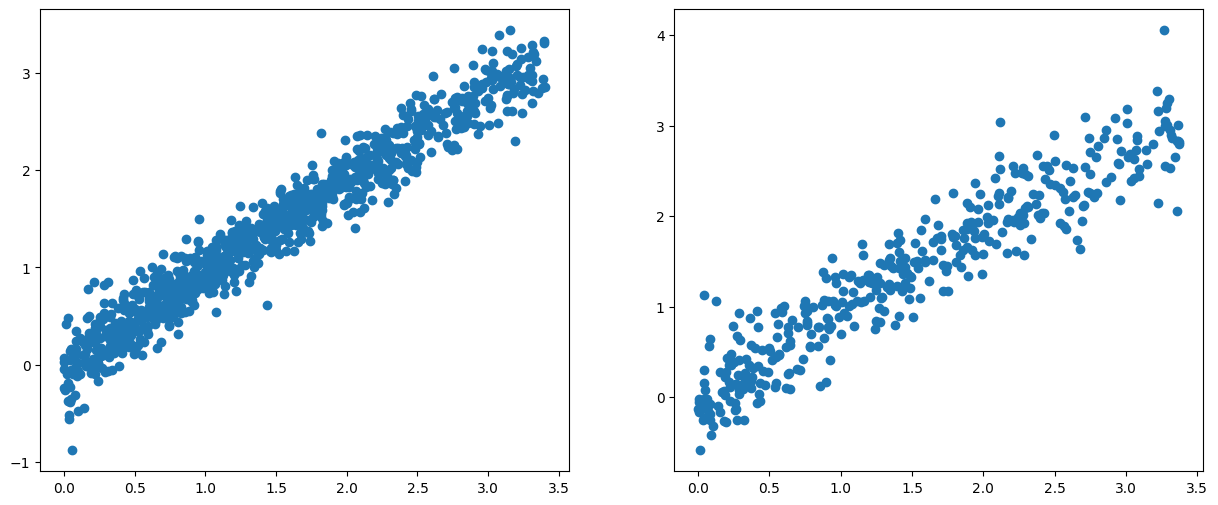

In [71]:
with torch.no_grad():
    eval_model = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./Chip'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print('(Train) MSPE: ',criterion(y_train, eval_model(X_train).detach()), '| (Test) MSPE: ',criterion(y_test, eval_model(X_test).detach()))
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.scatter(y_train, eval_model(X_train).detach())
    plt.subplot(1,2,2)
    plt.scatter(y_test, eval_model(X_test).detach())

### ECM Tuning

In [68]:
def ECM(premodel, num_neurons, num_knots, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi
    
    B = premodel.sp1.inter['eachbasic']
    By = premodel.sp1.inter['basicoutput']
    WB = premodel.sp1.control_p
    DB = diag_mat_weights(WB.size()[0]).to(device)
    size = B.size()[1]
    S = DB.T @ DB
    Cov_a = (xi**2)* torch.linalg.pinv(S)
    Cov_e = torch.eye(size*num_neurons)* sigma
    
    block_y = torch.reshape(By, (-1,1))
    flatB = B.view(num_neurons, num_knots, size)
        
    sqr_xi= 0
    sqr_sig = 0
    
    for i in range(num_neurons):
        Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
        Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
        
        first_xi = S @ Ncov
        second_xi = (Nmu.T @ S @ Nmu)
        sqr_xi += torch.trace(first_xi) + second_xi
            
        first_sig = torch.norm(By[:,i])
        second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
        third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
        four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
        
        sqr_sig += (first_sig + second_sig + third_sig + four_sig)
    
    sqr_xi /= num_neurons
    sqr_sig /= (num_neurons*size)
    
    Lambda = sqr_sig/sqr_xi
    
    return Lambda.item()

In [69]:
ECM_epoches = 10
with torch.no_grad():
    eval_model = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./Chip'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))

    WB = eval_model.sp1.control_p
    DB = diag_mat_weights(WB.size()[0], 'second').to(device)
    BestGCV = 9999
    n = X_train.size()[0]
    for i in range(ECM_epoches):
        MPSy = eval_model(X_train)
        LambdaB1 = ECM(premodel = eval_model, num_neurons = nm, num_knots = nk)        
        B1 = eval_model.sp1.inter['eachbasic']
        By1 = eval_model.sp1.inter['basicoutput']
        P2 = (torch.linalg.pinv(By1.T @ By1) @ By1.T @ By1)
        
        size1 = B1.size()[1]
        B1 = B1.view(nm, nk, size1)

        NW1 = torch.empty((nk, nm))
        NB1 = torch.empty((nm))
        for i in range(nm):
            B1y = By1[:,i] - eval_model.sp1.bias.data[i]
            BB1 = B1[i].T
            PB1 = (torch.linalg.pinv(BB1.T @ BB1) @ BB1.T @ BB1)
            
            # Update the weights and bias
            NW1[:, i] = (torch.inverse(BB1.T @ BB1 + (LambdaB1/size1) * (DB.T @ DB)) @ BB1.T @ B1y)
            NB1[i] = torch.mean(By1[:,i] - (NW1[:,i] @ BB1.T))
            
        # update the weight
        getattr(eval_model.sp1, 'control_p').data = NW1
        getattr(eval_model.sp1, 'bias').data = NB1
        

        MPSy = eval_model(X_train)
        trainloss = criterion(y_train, MPSy.detach()).item()
        GCV = trainloss*(n/(n-torch.trace(P2))**2)
        
        if GCV < BestGCV:
            BestLambdaB = LambdaB1
            BestGCV = GCV
            
        MPSy = eval_model(X_test)
        print('Lambda: ', np.round(LambdaB1, 5),'| Training Loss: ', trainloss,'| GCV: ', GCV,' | Testing Error: ', np.round(criterion(y_test, MPSy.detach()).item(), 5))

Lambda:  0.14148 | Training Loss:  0.0498352125287056 | GCV:  tensor(5.5219e-05)  | Testing Error:  0.11754
Lambda:  0.14149 | Training Loss:  0.049836210906505585 | GCV:  tensor(5.5220e-05)  | Testing Error:  0.11753
Lambda:  0.14149 | Training Loss:  0.049837272614240646 | GCV:  tensor(5.5221e-05)  | Testing Error:  0.11752
Lambda:  0.1415 | Training Loss:  0.049838341772556305 | GCV:  tensor(5.5223e-05)  | Testing Error:  0.1175
Lambda:  0.14151 | Training Loss:  0.04983942210674286 | GCV:  tensor(5.5224e-05)  | Testing Error:  0.11749
Lambda:  0.14151 | Training Loss:  0.04984049126505852 | GCV:  tensor(5.5225e-05)  | Testing Error:  0.11748
Lambda:  0.14152 | Training Loss:  0.049841612577438354 | GCV:  tensor(5.5226e-05)  | Testing Error:  0.11747
Lambda:  0.14153 | Training Loss:  0.049842748790979385 | GCV:  tensor(5.5227e-05)  | Testing Error:  0.11745
Lambda:  0.14153 | Training Loss:  0.049843888729810715 | GCV:  tensor(5.5229e-05)  | Testing Error:  0.11744
Lambda:  0.14154

## Penalized Algorithm

In [73]:
for d in range(1,2):
    DPS = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    DPS.load_state_dict(torch.load('./Chip'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    optimizer = torch.optim.Adam(DPS.parameters(), lr=1e-1)
    n = X_train.size()[0]

    with torch.no_grad():
        MBSy = DPS(X_test)
    
    for t in range(1, 1001):
                                           
        # Forward pass: Compute predicted y by passing x to the modelsp
        pyb_af = DPS(X_train)
        WB = DPS.sp1.control_p
        DB = diag_mat_weights(WB.size()[0]).to(device)

        loss = criterion(y_train, pyb_af) + (BestLambdaB/n) * torch.norm(DB @ WB)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if t % 50 == 0:
            with torch.no_grad():
                print(criterion(y_test, DPS(X_test).detach()).item())

with torch.no_grad():
    MPSy = DPS(X_test)
    print('MBS Testing Error: ', criterion(y_test, MBSy).item())
    print('MPS Testing Error: ', criterion(y_test, MPSy).item())

0.19601312279701233
0.1282314509153366
0.11588143557310104
0.11075561493635178
0.10846267640590668
0.10739194601774216
0.10680045932531357
0.10635945945978165
0.10592024028301239
0.10543016344308853
0.1048823669552803
0.10428395122289658
0.10364191979169846
0.10296030342578888
0.10224185883998871
0.10148961842060089
0.10070719569921494
0.09989915043115616
0.09907166659832001
0.09823209047317505
MBS Testing Error:  0.1175554171204567
MPS Testing Error:  0.09823209047317505


(Test) DNN-S MSPE:  tensor(0.1176) | (Test) DPS MSPE:  tensor(0.0982)


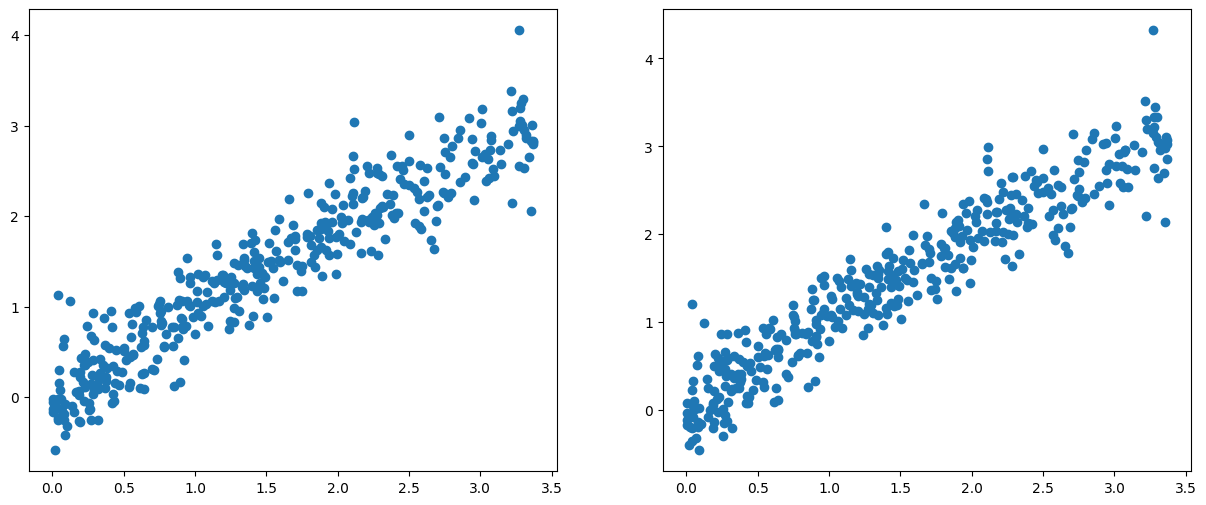

In [76]:
with torch.no_grad():
    model = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    model.load_state_dict(torch.load('./Chip'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    
    print('(Test) DNN-S MSPE: ', criterion(y_test, MBSy), '| (Test) DPS MSPE: ', criterion(y_test, MPSy))
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.scatter(y_test, model(X_test).detach())
    plt.subplot(1,2,2)
    plt.scatter(y_test, DPS(X_test).detach())

In [77]:
with torch.no_grad():
    MPSy = DPS(X_train)
    t_np = DPS.sp1.inter['basicoutput'].numpy() #convert to Numpy array
    df = pd.DataFrame(t_np) #convert to a dataframe
    df.to_csv("output_feature.csv",index=False) #save to file
    
    t_np = y_train.numpy() #convert to Numpy array
    df = pd.DataFrame(t_np) #convert to a dataframe
    df.to_csv("output_eta.csv",index=False) #save to file

In [78]:
with torch.no_grad():
    MPSy = DPS(X_test)
    t_np = DPS.sp1.inter['basicoutput'].numpy() #convert to Numpy array
    df = pd.DataFrame(t_np) #convert to a dataframe
    df.to_csv("test_output_feature.csv",index=False) #save to file
    
    t_np = y_test.numpy() #convert to Numpy array
    df = pd.DataFrame(t_np) #convert to a dataframe
    df.to_csv("test_output_eta.csv",index=False) #save to file

In [89]:
print('max eta: ', y_test[250].item())
print('corresponding beta: ', X_test[250, 5].item())

max eta:  3.2690844535827637
corresponding beta:  0.041219424456357956


In [323]:
class MPSv3(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, output_dim, bias):
        super(MPSv3, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        self.nm1 = NormLayer() 
        self.sp1 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.nm2 = NormLayer() 
        self.sp2 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        #self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.1)
        self.inter = {}
        
    def forward(self, x):
        ln1out = self.ln1(x)
        ln1out = self.nm1(ln1out)
        #ln1out = self.drop1(ln1out)
        
        device = ln1out.device
        batch_size, _ = x.size()
        
        # # # # # # # # # # # # # #
        #         SPLINE 1        #
        # # # # # # # # # # # # # #
        
        sp1out = self.sp1(ln1out)
        bslist = self.sp1.inter['basic']
        
        self.inter['ebasic'] = bslist
        self.inter['basic'] = sp1out

        # # # # # # # # # # # # # #
        #         SPLINE 1        #
        # # # # # # # # # # # # # #
        
        sp2out = self.sp2(ln1out)
        bslist2 = self.sp2.inter['basic']
        
        self.inter['ebasic2'] = bslist2
        self.inter['basic2'] = sp2out

        ln2out = self.ln2(sp2out)
        #ln2out = self.relu(ln2out)
        
        return ln2out

In [325]:
nm = 50; dg = 3; L = 1; nk = 15; Fin = ndim; Fout = 1;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


MBS = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
print('Number of Parameters: ', num_para(MBS))

################################################
#        Example 3 use learning rate 1e-3      #
################################################
#    Example 1 and 2 use learning rate 1e-2    #
################################################

learning_r = 5e-2
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(MBS.parameters(), lr=learning_r)

Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = 9999

for t in range(Iteration):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = MBS(X_train)
    loss = criterion(y_train, pyb_af); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(MBS.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            torch.save(MBS.state_dict(), './1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')


with torch.no_grad():
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

Number of Parameters:  2151
Current loss:  74.31002807617188  | , previous best loss:  9999  | saving best model ...
Current loss:  49.61920928955078  | , previous best loss:  74.31002807617188  | saving best model ...
Current loss:  42.599998474121094  | , previous best loss:  49.61920928955078  | saving best model ...
Current loss:  41.204532623291016  | , previous best loss:  42.599998474121094  | saving best model ...
Current loss:  40.813201904296875  | , previous best loss:  41.204532623291016  | saving best model ...
Current loss:  40.00410079956055  | , previous best loss:  40.813201904296875  | saving best model ...
Current loss:  38.6414680480957  | , previous best loss:  40.00410079956055  | saving best model ...
Current loss:  38.03885269165039  | , previous best loss:  38.6414680480957  | saving best model ...
Current loss:  37.97364044189453  | , previous best loss:  38.03885269165039  | saving best model ...
Current loss:  37.01789093017578  | , previous best loss:  37.9

tensor(13.7425)


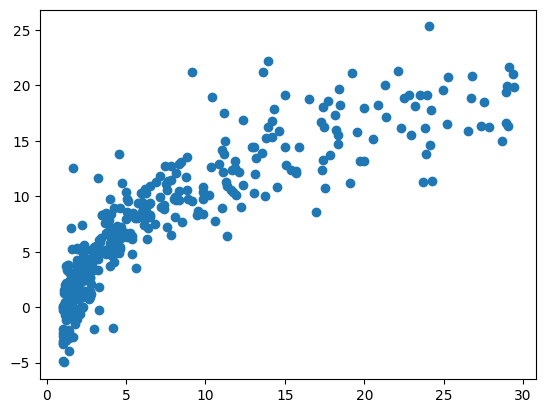

In [327]:
with torch.no_grad():
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))
    plt.scatter(y_test, eval_model(X_test).detach())

### Penalized model

In [ ]:
with torch.no_grad():
    print('------------------------------------------')
    print('Before adding penalty ... ')
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print('Training Error: ', np.round(criterion(y_train, eval_model(X_train).detach()).item(), 5), ' | Testing Error: ', np.round(criterion(y_test, eval_model(X_test).detach()).item(), 5))
    print('------------------------------------------')
    print('After adding penalty ... ')

    
    WB = eval_model.sp1.control_p
    DB = diag_mat_weights(WB.size()[0], 'second').to(device)
    BestGCV = 9999
    
    for i in range(10):
        MPSy = eval_model(X_train)
        LambdaB1 = ECM(model = eval_model, num_neurons = nm, num_knots = nk, L = 1)
        LambdaB2 = ECM(model = eval_model, num_neurons = nm, num_knots = nk, L = 2)
        
        B1 = eval_model.inter['ebasic']
        B2 = eval_model.inter['ebasic2']
        P2 = (torch.linalg.pinv(B2.T @ B2) @ B2.T @ B2)
        
        By1 = eval_model.inter['basic']
        By2 = eval_model.inter['basic2']
        
        size1 = B1.size()[1]
        size2 = B2.size()[1]

        B1 = B1.view(nm, nk, size1)
        B2 = B2.view(nm, nk, size2)

        NW1 = torch.empty((nk, nm))
        NW2 = torch.empty((nk, nm))
        NB1 = torch.empty((nm))
        NB2 = torch.empty((nm))
        for i in range(nm):
            B1y = By1[:,i] - eval_model.sp1.bias.data[i]
            B2y = By2[:,i] - eval_model.sp2.bias.data[i]

            BB1 = B1[i].T
            BB2 = B2[i].T
            PB1 = (torch.linalg.pinv(BB1.T @ BB1) @ BB1.T @ BB1)
            PB2 = (torch.linalg.pinv(BB2.T @ BB2) @ BB2.T @ BB2)

            # Update the weights and bias
            NW1[:, i] = (torch.inverse(BB1.T @ BB1 + (LambdaB1/size1) * (DB.T @ DB)) @ BB1.T @ B1y)
            NW2[:, i] = (torch.inverse(BB2.T @ BB2 + (LambdaB2/size2) * (DB.T @ DB)) @ BB2.T @ B2y)
            NB1[i] = torch.mean(By1[:,i] - (NW1[:,i] @ BB1.T))
            NB2[i] = torch.mean(By2[:,i] - (NW2[:,i] @ BB2.T))
            
        # update the weight
        getattr(eval_model.sp1, 'control_p').data = NW1
        getattr(eval_model.sp2, 'control_p').data = NW2
        getattr(eval_model.sp1, 'bias').data = NB1
        getattr(eval_model.sp2, 'bias').data = NB2
        

        MPSy = eval_model(X_train)
        trainloss = np.round(criterion(y_train, MPSy.detach()).item(), 5)
        GCV = np.round((torch.norm(y_train - MPSy)/(size2-torch.trace(P2))).item(), 5)
        
        if GCV < BestGCV:
            BestLambdaB1, BestLambdaB2 = LambdaB1, LambdaB2
            BestGCV = GCV
            
        MPSy = eval_model(X_test)
        print('Lambda: ', np.round(LambdaB1, 5),' and ', np.round(LambdaB2, 5),'| Training Loss: ', trainloss,'| GCV: ', GCV,' | Testing Error: ', np.round(criterion(y_test, MPSy.detach()).item(), 5))

In [244]:
nm = 50; dg = 3; L = 1; nk = 10; Fin = ndim; Fout = 1;

eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
eval_model.load_state_dict(torch.load('./1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))


################################################
#        Example 3 use learning rate 1e-3      #
################################################
#    Example 1 and 2 use learning rate 1e-2    #
################################################
learning_r = 1e-3

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(eval_model.parameters(), lr=learning_r)

fast_tune = 1001; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = 9999
n = X_train.size()[0]

for t in range(1, fast_tune):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = eval_model(X_train)
    WB1 = eval_model.sp1.control_p.data; WB2 = eval_model.sp2.control_p.data
    DB1 = diag_mat_weights(WB1.size()[0]).to(device); DB2 = diag_mat_weights(WB2.size()[0]).to(device)

    loss = criterion(y_train, pyb_af) + (BestLambdaB1/n) * torch.norm(DB1 @ WB1) + (BestLambdaB2/n) * torch.norm(DB2 @ WB2)
    bloss_list.append(loss.item())

    '''
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(MBS.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            torch.save(MBS.state_dict(), './1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
    '''
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 100 == 0:
        with torch.no_grad():
            print(criterion(y_test, eval_model(X_test).detach()))
            
    #print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')


with torch.no_grad():
    print(criterion(y_test, eval_model(X_test).detach()))

tensor(0.0006)
tensor(0.0004)
tensor(0.0003)
tensor(0.0003)
tensor(0.0002)
tensor(0.0002)
tensor(0.0002)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)


In [51]:
class MLNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLNet, self).__init__()
        self.ln1 = nn.Linear(input_dim, 30)
        self.relu1 = nn.ReLU()
        self.ln2 = nn.Linear(30, 30)
        self.relu2 = nn.ReLU()
        self.ln3 = nn.Linear(30, output_dim)
        self.relu3 = nn.ReLU()
        
    def forward(self, x):
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.ln3(x)
        output = self.relu3(x)
        
        return output

In [72]:
ML = MLNet(ndim, 1)
print('Number of parameter: ', num_para(ML))
learning_r = 1e-4
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(ML.parameters(), lr=learning_r)
Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = 9999

for t in range(Iteration):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = ML(X_train)
    loss = criterion(y_train, pyb_af); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(ML.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            #torch.save(MBS.state_dict(), './EXA'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk)+'data'+str(d+1))
            bloss = loss.item()
            tpat = 0
        tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')

Current loss:  0.5207098126411438  | , previous best loss:  9999  | saving best model ...
| Epoch:  1 / 10000  | Loss:  0.5207  |
Current loss:  0.5193433165550232  | , previous best loss:  0.5207098126411438  | saving best model ...
| Epoch:  2 / 10000  | Loss:  0.5193  |
Current loss:  0.5179778337478638  | , previous best loss:  0.5193433165550232  | saving best model ...
| Epoch:  3 / 10000  | Loss:  0.518  |
Current loss:  0.5166123509407043  | , previous best loss:  0.5179778337478638  | saving best model ...
| Epoch:  4 / 10000  | Loss:  0.5166  |
Current loss:  0.5152472853660583  | , previous best loss:  0.5166123509407043  | saving best model ...
| Epoch:  5 / 10000  | Loss:  0.5152  |
Current loss:  0.5138829350471497  | , previous best loss:  0.5152472853660583  | saving best model ...
| Epoch:  6 / 10000  | Loss:  0.5139  |
Current loss:  0.5125197768211365  | , previous best loss:  0.5138829350471497  | saving best model ...
| Epoch:  7 / 10000  | Loss:  0.5125  |
Current

In [73]:
with torch.no_grad():
    print(criterion(y_test, ML(X_test).detach()))

tensor(0.0019)


In [485]:
MPS = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
learning_r = 1e-2
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(MPS.parameters(), lr=learning_r)

Iteration = 10000
ploss_list = []
bloss = 9999

tpat = 0
patientc = 20
patientr = 5
lr_tor = 1e-7
n = X_train.size()[0]

for t in range(Iteration):
    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = MPS(X_train)
    
    # Extracted the feature from model
    WB1 = MPS.sp1.control_p; DB1 = diag_mat_weights(WB1.size()[0]).to(device)
    
    # Calculate the MSELoss & penalty
    loss = criterion(y_train, pyb_af) 
    penalty = LambdaB * torch.norm(DB1 @ WB1)*(1/nm) 
    #penalty = 4.9 * torch.norm(DB1 @ WB1)*(1/n) 
    #+ (Lambdadict['L']/n) * torch.norm(DL @ WL.T)
    loss += penalty
    
    ploss_list.append(loss.item())
    

    if (t > 0) and ((ploss_list[t-1]-ploss_list[t])<tor):        
        if  (tpat % patientr) == 0 :
            learning_r *= 0.2 
            tpat += 1
            print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(MPS.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
    else:
        if loss < bloss:
            print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            torch.save(MPS.state_dict(), './1BestMPSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        tpat += 1
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')

Current loss:  0.7689186334609985  | , previous best loss:  9999  | saving best model ...
| Epoch:  1 / 10000  | Loss:  0.7689  |
| Epoch:  2 / 10000  | Loss:  0.8576  |
Current loss:  0.7505857944488525  | , previous best loss:  0.7689186334609985  | saving best model ...
| Epoch:  3 / 10000  | Loss:  0.7506  |
Current loss:  0.73035728931427  | , previous best loss:  0.7505857944488525  | saving best model ...
| Epoch:  4 / 10000  | Loss:  0.7304  |
| Epoch:  5 / 10000  | Loss:  0.7699  |
| Epoch:  6 / 10000  | Loss:  0.7433  |
Current loss:  0.7008974552154541  | , previous best loss:  0.73035728931427  | saving best model ...
| Epoch:  7 / 10000  | Loss:  0.7009  |
Current loss:  0.6980769634246826  | , previous best loss:  0.7008974552154541  | saving best model ...
| Epoch:  8 / 10000  | Loss:  0.6981  |
| Epoch:  9 / 10000  | Loss:  0.7145  |
| Epoch:  10 / 10000  | Loss:  0.7072  |
Current loss:  0.6810963153839111  | , previous best loss:  0.6980769634246826  | saving best mod

In [492]:
with torch.no_grad():
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./1BestMPSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

tensor(1.5192)


In [490]:
MPSy = eval_model(X_train)
LambdaB = ECM(model = eval_model, num_neurons = nm, num_knots = nk)
print('Lambda: ', LambdaB)

Lambda:  0.5584757328033447


## 

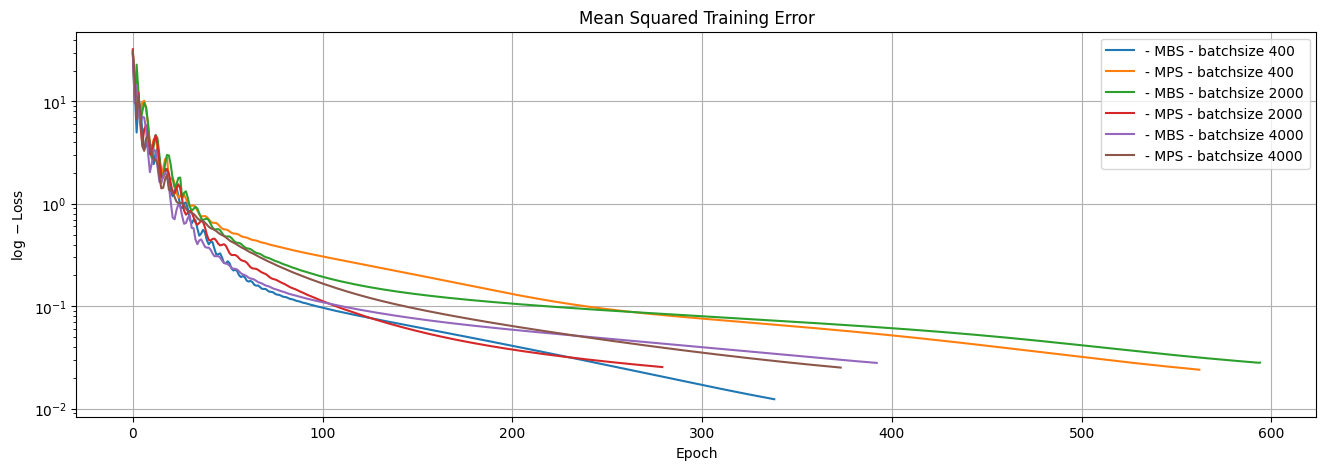

In [249]:
plt.figure(figsize=(16,5))
plt.plot(np.arange(len(Lossdict['MBS400'][:-4])), Lossdict['MBS400'][:-4], label = '- MBS - batchsize 400')
plt.plot(np.arange(len(Lossdict['MPS400'][:-27])), Lossdict['MPS400'][:-27], label = '- MPS - batchsize 400')
plt.plot(np.arange(len(Lossdict['MBS2000'][:-27])), Lossdict['MBS2000'][:-27], label = '- MBS - batchsize 2000')
plt.plot(np.arange(len(Lossdict['MPS2000'][:-6])), Lossdict['MPS2000'][:-6], label = '- MPS - batchsize 2000')
plt.plot(np.arange(len(Lossdict['MBS4000'][:-35])), Lossdict['MBS4000'][:-35], label = '- MBS - batchsize 4000')
plt.plot(np.arange(len(Lossdict['MPS4000'][:-6])), Lossdict['MPS4000'][:-6], label = '- MPS - batchsize 4000')
plt.yscale("log")
plt.title('Mean Squared Training Error')
plt.xlabel('Epoch')
plt.ylabel('$\log-$Loss')
plt.legend()
plt.savefig('training_loss.png')
plt.grid()

### Parameter sum

In [358]:
with torch.no_grad():
    X_test = torch.load('../Dataset/train400.pt', weights_only = True)['X_test']
    y_test = torch.load('../Dataset/train400.pt', weights_only = True)['y_test']

    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMBSn400'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMPSn400'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

    X_test = torch.load('../Dataset/train2000.pt', weights_only = True)['X_test']
    y_test = torch.load('../Dataset/train2000.pt', weights_only = True)['y_test']

    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMBSn2000'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))
    
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMPSn2000'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

    X_test = torch.load('../Dataset/train4000.pt', weights_only = True)['X_test']
    y_test = torch.load('../Dataset/train4000.pt', weights_only = True)['y_test']
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMBSn4000'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMPSn4000'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

tensor(0.0359)
tensor(0.0546)
tensor(0.0302)
tensor(0.0265)
tensor(0.0303)
tensor(0.0266)


In [405]:
cat_dict = {}
sizel = ['400', '2000', '4000']

for s in sizel:
    with torch.no_grad():
        eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
        eval_model.load_state_dict(torch.load('./BestMBSn'+s+'h'+str(nm)+'k'+str(nk), weights_only = True))
        
    cat_par = None
    for name, param in eval_model.named_parameters():
        if param.requires_grad:
            if cat_par is None:
                cat_par = param.data.reshape(-1,1)
            else:
                cat_par = torch.cat([cat_par, param.data.reshape(-1,1)], dim = 0)

    par = cat_par.detach().numpy().reshape(-1)
    par = par * np.std(par)
    
    cat_dict['b'+s] = list(par)
    
sizel = ['400', '2000', '4000']

for s in sizel:
    with torch.no_grad():
        eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
        eval_model.load_state_dict(torch.load('./BestMPSn'+s+'h'+str(nm)+'k'+str(nk), weights_only = True))
        
    cat_par = None
    for name, param in eval_model.named_parameters():
        if param.requires_grad:
            if cat_par is None:
                cat_par = param.data.reshape(-1,1)
            else:
                cat_par = torch.cat([cat_par, param.data.reshape(-1,1)], dim = 0)

    par = cat_par.detach().numpy().reshape(-1)
    par *= np.std(par)
    cat_dict['p'+s] = list(par)

In [409]:
cat = ['MBS(400)'] * len(cat_par) + ['MPS(400)'] * len(cat_par) + ['MBS(2000'] * len(cat_par) + ['MPS(2000)'] * len(cat_par) + ['MBS(4000)'] * len(cat_par)  + ['MPS(4000)'] * len(cat_par)
para = cat_dict['b400'] +  cat_dict['p400']  + cat_dict['b2000'] + cat_dict['p2000'] + cat_dict['b4000'] + cat_dict['p4000']
df = pd.DataFrame({'Class': cat, 'para': para})

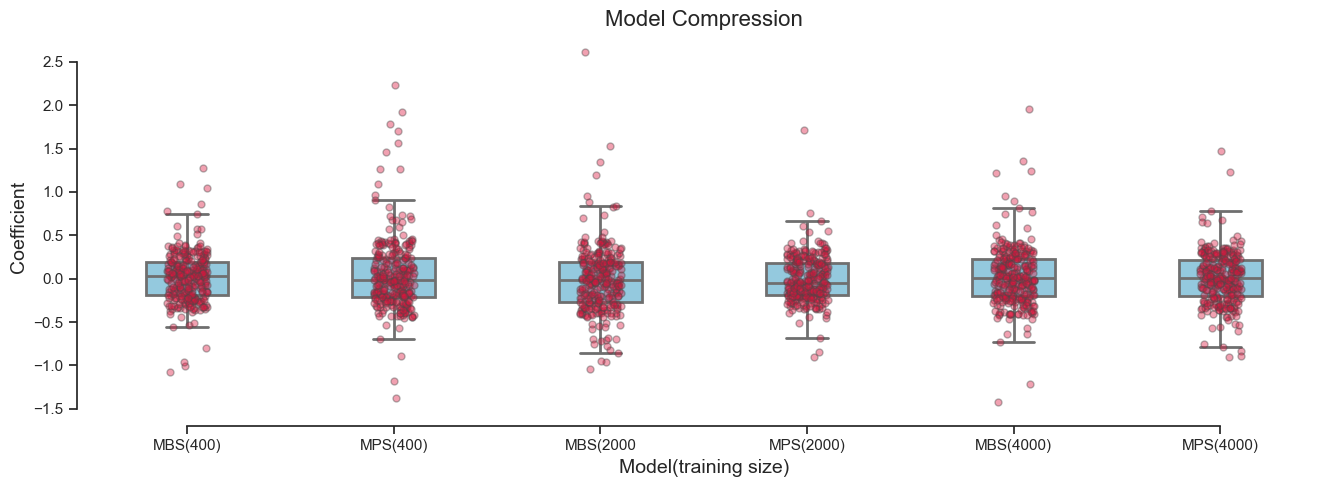

In [413]:
# Change some of seaborn's style settings with `sns.set()`
plt.figure(figsize = (16, 5))
sns.set(
        style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (6, 9),      # width = 6, height = 9
            "figure.facecolor": "white",  # Figure colour
            "axes.facecolor": "white"})  # Axes colour# Box plot
b = sns.boxplot(data = df,           
                    x = "Class",       # x axis column from data
                    y = "para",       # y axis column from data
                    width = 0.4,        # The width of the boxes
                    color = "skyblue",  # Box colour
                    linewidth = 2,      # Thickness of the box lines
                    showfliers = False)  # Sop showing the fliers# Strip plot
b = sns.stripplot(data = df,          
                      x = "Class",      # x axis column from data
                      y = "para",      # y axis column from data
                      color = "crimson", # Colours the dots
                      linewidth = 1,     # Dot outline width
                      alpha = 0.4)       # Makes them transparent# Set the y axis and font size
b.set_ylabel("Coefficient", fontsize = 14)# Set the x axis label and font size
b.set_xlabel("Model(training size)", fontsize = 14)# Set the plot title with the pval variable and font size
b.set_title("Model Compression", fontsize = 16)# Remove axis spines
sns.despine(offset = 5, trim = True)# Show the figure
b.get_figure();

plt.savefig('boxcoef.png')

## Nouse Function 

In [ ]:
'''
def ECM(model, num_neurons, num_knots, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi
    
    B = model.inter['ebasic']
    By = model.inter['basic']
    WB = model.sp1.control_p
    DB = diag_mat_weights(WB.size()[0]).to(device)
    size = B.size()[1]
    S = DB.T @ DB
    Cov_a = (xi**2)* torch.linalg.pinv(S)
    Cov_e = torch.eye(size*num_neurons)* sigma
    
    block_y = torch.reshape(By, (-1,1))
    flatB = B.view(num_neurons, num_knots, size)
        
    sqr_xi= 0
    sqr_sig = 0
    
    for i in range(num_neurons):
        Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
        Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
        
        first_xi = S @ Ncov
        second_xi = (Nmu.T @ S @ Nmu)
        sqr_xi += torch.trace(first_xi) + second_xi
            
        first_sig = torch.norm(By[:,i])
        second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
        third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
        four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
        
        sqr_sig += (first_sig + second_sig + third_sig + four_sig)
    
    sqr_xi /= num_neurons
    sqr_sig /= (num_neurons*size)
    
    Lambda = sqr_sig/sqr_xi
    
    return Lambda.item()
